No data found for MRO


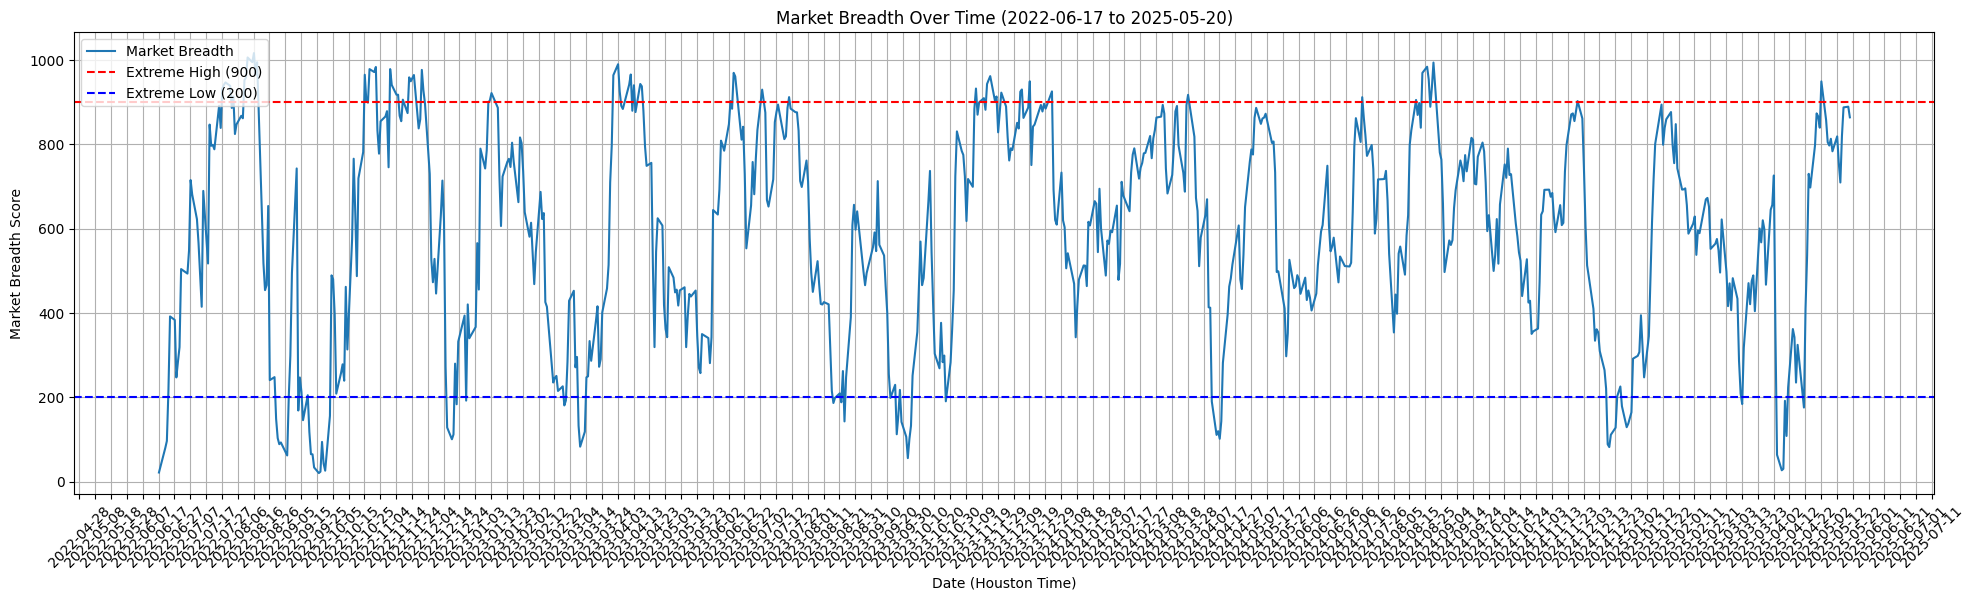

C:\Users\Rhino\AppData\Local\Temp\ipykernel_22584\3746110043.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(sector_scores_df.columns, rotation=45)


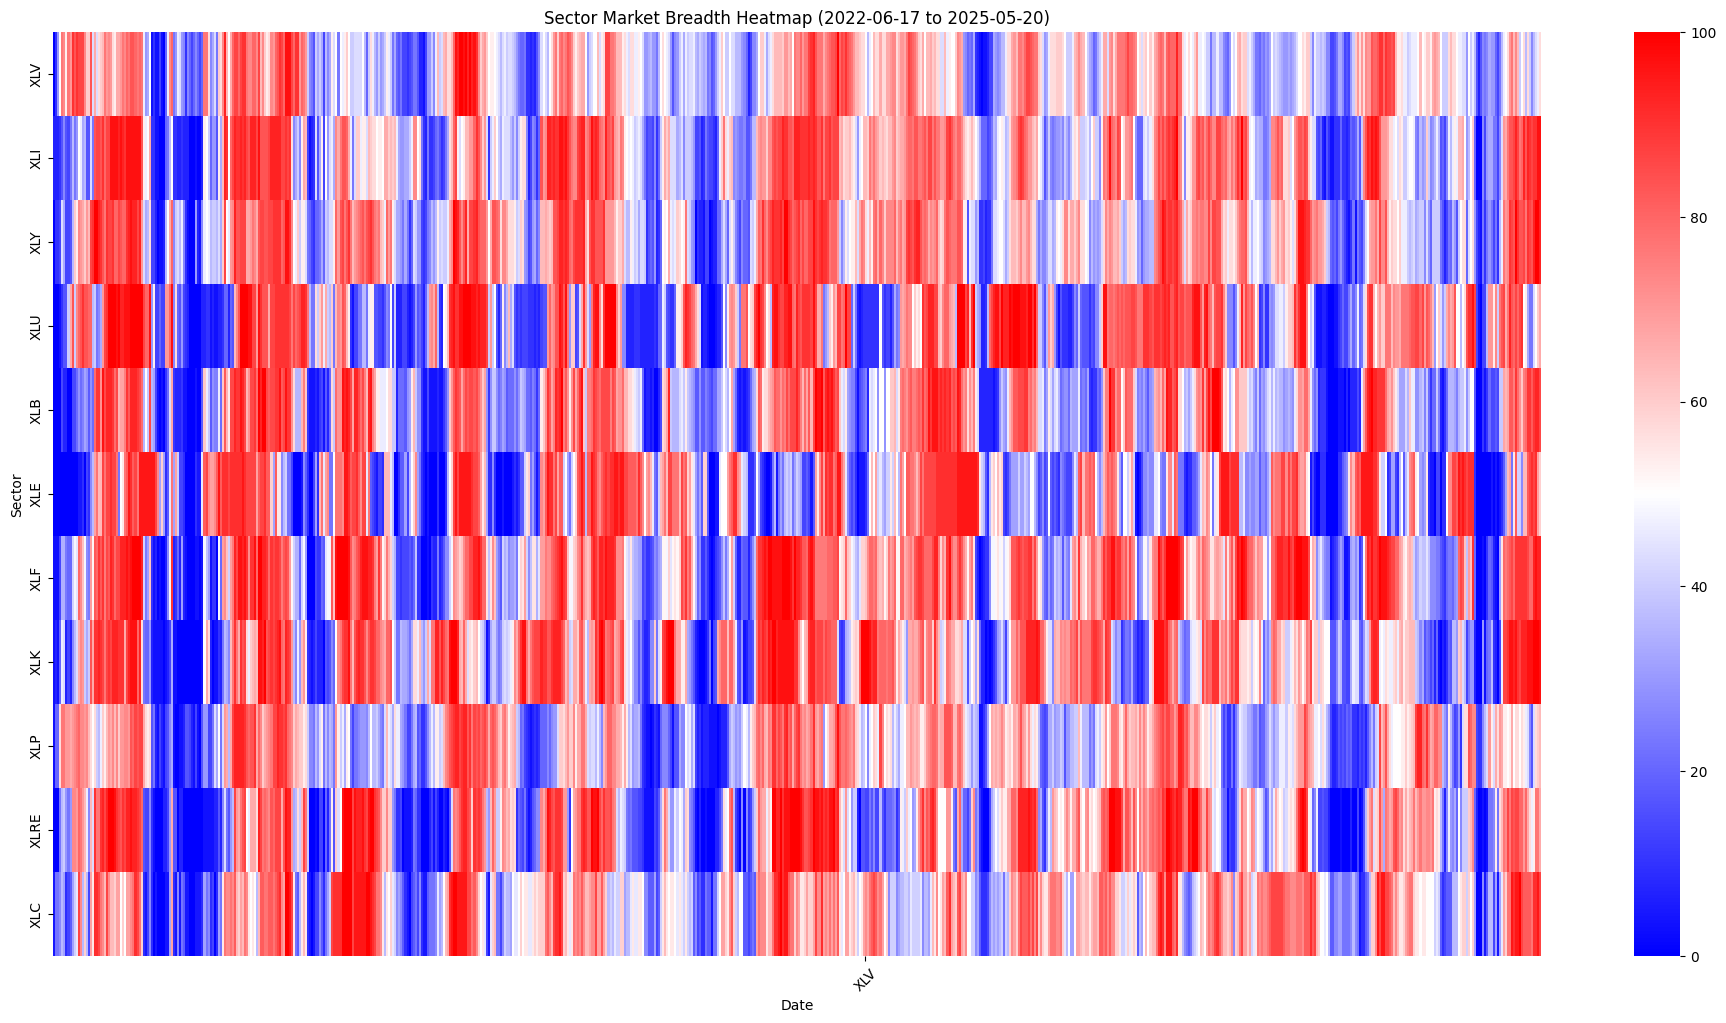

In [5]:
import seaborn as sns
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
import pytz

%run constant.ipynb

# 获取股票的历史数据
def get_historical_data(symbol, access_token, period_type='year', period=3, frequency_type='daily', frequency=1):
    base_url = 'https://api.schwabapi.com/marketdata/v1/pricehistory'
    headers = {
        'accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'symbol': symbol,
        'periodType': period_type,
        'period': period,
        'frequencyType': frequency_type,
        'frequency': frequency,       
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Failed to fetch data for {symbol}: {response.status_code}")
        return None

    try:
        data = response.json()
        if 'candles' not in data or not data['candles']:
            print(f"No data found for {symbol}")
            return None
        df = pd.DataFrame(data['candles'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')  # 将datetime字段转换为日期时间格式
        return df
    except ValueError:
        print(f"Failed to parse JSON for {symbol}")
        return None

# 计算市场宽度
def calculate_market_breadth(sector_stocks, access_token):
    sector_breadth = pd.Series(dtype=float)
    for stock in sector_stocks:
        data = get_historical_data(stock, access_token)
        if data is not None and not data.empty:
            data['MA20'] = data['close'].rolling(window=20).mean()
            data = data.dropna()  # 去掉没有20日移动平均线的天数
            data['Above_MA20'] = data['close'] > data['MA20']
            sector_breadth = sector_breadth.add(data.set_index('datetime')['Above_MA20'], fill_value=0)
    
    if sector_breadth.empty:
        return None
    
    # 计算每个板块的平均分数
    sector_breadth = (sector_breadth / len(sector_stocks)) * 100
    return sector_breadth

# 假设我们有11个sector，每个sector包含若干股票
sectors = {    
    "XLV": ["LLY", "UNH", "JNJ", "ABBV", "MRK", "TMO", "ABT", "DHR", "AMGN", "ISRG","PFE", "REGN", "ELV", "VRTX", "BSX", "SYK", "MDT", "BMY", "CI", "GILD","ZTS", "CVS", "HCA", "MCK", "BDX", "IQV", "HUM", "CNC", "A", "EW"],
    "XLI": ["GE", "CAT", "RTX", "UBER", "UNP", "HON", "LMT", "ETN", "ADP", "BA",
    "DE", "UPS", "TT", "WM", "PH", "TDG", "MMM", "NOC", "GD", "CTAS",
    "ITW", "CSX", "FDX", "EMR", "CARR", "NSC", "GEV", "PCAR", "URI", "JCI"],
    "XLY": ["AMZN", "TSLA", "HD", "MCD", "LOW", "TJX", "BKNG", "SBUX", "NKE", "CMG",
    "ORLY", "AZO", "MAR", "DHI", "HLT", "ABNB", "GM", "ROST", "LEN", "F",
    "YUM", "RCL", "LULU", "EBAY", "TSCO", "NVR", "GRMN", "PHM", "DECK", "GPC"],
    "XLU": ["NEE", "SO", "DUK", "CEG", "AEP", "SRE", "D", "PEG", "PCG", "EXC",
    "ED", "XEL", "EIX", "WEC", "AWK", "VST", "DTE", "ETR", "ES", "PPL",
    "FE", "AEE", "CMS", "ATO", "NRG", "CNP", "LNT", "NI", "EVRG", "AES"],
    "XLB": ["LIN", "SHW", "FCX", "ECL", "APD", "NEM", "CTVA", "DOW", "NUE", "DD",
    "MLM", "VMC", "PPG", "IFF", "LYB", "SW", "BALL", "PKG", "AVY", "STLD",
    "IP", "AMCR", "CF", "CE", "EMN", "ALB", "MOS", "FMC"],
    "XLE": [  "XOM", "CVX", "EOG", "SLB", "MPC", "COP", "PSX", "WMB", "OKE", "VLO",
    "KMI", "OXY", "HES", "BKR", "FANG", "TRGP", "DVN", "HAL", "EQT", "CTRA",
    "MRO", "APA"],
    "XLF": ["JPM", "V", "MA", "BAC", "WFC", "GS", "SPGI", "AXP", "PGR",
    "MS", "BLK", "C", "CB", "MMC", "FI", "SCHW", "BX", "ICE", "KKR",
    "CME", "MCO", "AON", "PYPL", "PNC", "USB", "AJG", "TFC", "COF", "AFL"],
    "XLK": ["NVDA", "MSFT", "AAPL", "AVGO", "CRM", "ADBE", "AMD", "ORCL", "ACN", "CSCO",
    "QCOM", "INTU", "TXN", "IBM", "AMAT", "NOW", "MU", "LRCX", "ADI", "PANW",
    "KLAC", "INTC", "ANET", "SNPS", "APH", "CDNS", "MSI", "NXPI", "CRWD", "ROP"],
    "XLP": ["PG", "COST", "WMT", "KO", "PM", "PEP", "MDLZ", "MO", "CL", "TGT",
    "KMB", "KVUE", "GIS", "STZ", "SYY", "KDP", "KR", "MNST", "ADM", "HSY",
    "KHC", "DG", "CHD", "EL", "K", "DLTR", "MKC", "CLX", "TSN", "CAG"], 
    "XLRE": ["PLD", "AMT", "EQIX", "WELL", "O", "SPG", "PSA", "DLR", "CCI", "EXR",
    "CBRE", "VICI", "IRM", "AVB", "CSGP", "EQR", "VTR", "SBAC", "WY", "INVH",
    "ESS", "ARE", "MAA", "DOC", "KIM", "CPT", "UDR", "HST", "REG", "BXP"],
    "XLC": ["META", "GOOGL", "GOOG", "CHTR", "TMUS", "T", "EA", "CMCSA", "NFLX", "VZ",
    "DIS", "TTWO", "OMC", "WBD", "LYV", "IPG", "NWSA", "MTCH", "FOXA", "PARA", 
    "FOX", "NWS"]
}

access_token = get_new_tokens()

# 计算每个sector的市场宽度
sector_scores = {}
total_market_breadth = pd.Series(dtype=float)
for sector, stocks in sectors.items():
    sector_breadth = calculate_market_breadth(stocks, access_token)
    if sector_breadth is not None:
        sector_scores[sector] = sector_breadth
        total_market_breadth = total_market_breadth.add(sector_breadth, fill_value=0)

# 计算总市场宽度
if not total_market_breadth.empty:
    # 设置休斯顿时区
    houston_tz = pytz.timezone('America/Chicago')
    
    # 获取日期索引并转换为休斯顿时间
    total_market_breadth.index = total_market_breadth.index.tz_localize('UTC').tz_convert(houston_tz)
    
    # 获取开始和结束日期
    start_date = total_market_breadth.index.min().strftime('%Y-%m-%d')
    end_date = total_market_breadth.index.max().strftime('%Y-%m-%d')

    # 绘制市场宽度图表
    plt.figure(figsize=(24, 6))
    plt.plot(total_market_breadth, label='Market Breadth')

    # 添加横线
    plt.axhline(900, color='red', linestyle='--', label='Extreme High (900)')
    plt.axhline(200, color='blue', linestyle='--', label='Extreme Low (200)')

    # 设置日期格式
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both', nbins=int(len(total_market_breadth) / 5)))
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

    plt.title(f'Market Breadth Over Time ({start_date} to {end_date})')
    plt.xlabel('Date (Houston Time)')
    plt.ylabel('Market Breadth Score')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.savefig('marketBreath-3Y.png')
    plt.show()
    
    # 转换sector_scores为DataFrame用于绘制热力图
    sector_scores_df = pd.DataFrame(sector_scores)
    
    # 将索引转换为日期格式
    sector_scores_df.index = sector_scores_df.index.tz_localize('UTC').tz_convert(houston_tz)
    sector_scores_df.index = pd.to_datetime(sector_scores_df.index).strftime('%Y-%m-%d')
    
    # 确保所有数据都是数字类型，并处理NaN值
    sector_scores_df = sector_scores_df.apply(pd.to_numeric, errors='coerce')
    sector_scores_df.fillna(0, inplace=True)  # 或者你可以使用 sector_scores_df.dropna()
    
    # 创建自定义的 colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)
    
    # 绘制热力图
    plt.figure(figsize=(24, 12))
    sns.heatmap(sector_scores_df.T, cmap=cmap, cbar=True, center=50)
    
    # 设置日期格式和间隔
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both', nbins=sector_scores_df.shape[1] // 5))
    plt.gca().set_xticklabels(sector_scores_df.columns, rotation=45)
    
    plt.title(f'Sector Market Breadth Heatmap ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Sector')
    plt.savefig('sectorHeatmap-3Y.png')
    plt.show()


else:
    print("No valid market breadth data to plot.")


In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

def get_historical_data(symbol, access_token, period_type='year', period=3, frequency_type='daily', frequency=1):
    base_url = 'https://api.schwabapi.com/marketdata/v1/pricehistory'
    headers = {
        'accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'symbol': symbol,
        'periodType': period_type,
        'period': period,
        'frequencyType': frequency_type,
        'frequency': frequency,       
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Failed to fetch data for {symbol}: {response.status_code}")
        return None

    try:
        data = response.json()
        if 'candles' not in data or not data['candles']:
            print(f"No data found for {symbol}")
            return None
        df = pd.DataFrame(data['candles'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        df['pct_change'] = df['close'].pct_change() * 100
        return df.dropna()
    except ValueError:
        print(f"Failed to parse JSON for {symbol}")
        return None

def calculate_contrarian_indicator(stocks, access_token):
    # Get SPY data (using original API parameters)
    spy_data = get_historical_data('SPY', access_token)
    if spy_data is None:
        print("Failed to get SPY data")
        return None
    
    # Get last 90 days of data
    spy_data = spy_data.tail(90)
    spy_changes = dict(zip(spy_data['datetime'], spy_data['pct_change']))
    
    contrarian_scores = {}
    
    for stock in stocks:
        stock_data = get_historical_data(stock, access_token)
        if stock_data is None:
            continue
            
        # Get last 90 days of data
        stock_data = stock_data.tail(90)
        contrarian_count = 0
        
        for _, row in stock_data.iterrows():
            date = row['datetime']
            stock_change = row['pct_change']
            
            if date in spy_changes:
                spy_change = spy_changes[date]
                
                if (spy_change > 0.3 and stock_change < -0.3) or (spy_change < -0.3 and stock_change > 0.3):
                    contrarian_count += 1
        
        contrarian_scores[stock] = contrarian_count
    
    return contrarian_scores

# Sector definitions (unchanged)
sectors = {    
    "XLV": ["LLY", "UNH", "JNJ", "ABBV", "MRK", "TMO", "ABT", "DHR", "AMGN", "ISRG","PFE", "REGN", "ELV", "VRTX", "BSX", "SYK", "MDT", "BMY", "CI", "GILD","ZTS", "CVS", "HCA", "MCK", "BDX", "IQV", "HUM", "CNC", "A", "EW"],
    "XLI": ["GE", "CAT", "RTX", "UBER", "UNP", "HON", "LMT", "ETN", "ADP", "BA", "DE", "UPS", "TT", "WM", "PH", "TDG", "MMM", "NOC", "GD", "CTAS", "ITW", "CSX", "FDX", "EMR", "CARR", "NSC", "GEV", "PCAR", "URI", "JCI"],
    "XLY": ["AMZN", "TSLA", "HD", "MCD", "LOW", "TJX", "BKNG", "SBUX", "NKE", "CMG", "ORLY", "AZO", "MAR", "DHI", "HLT", "ABNB", "GM", "ROST", "LEN", "F", "YUM", "RCL", "LULU", "EBAY", "TSCO", "NVR", "GRMN", "PHM", "DECK", "GPC"],
    "XLU": ["NEE", "SO", "DUK", "CEG", "AEP", "SRE", "D", "PEG", "PCG", "EXC", "ED", "XEL", "EIX", "WEC", "AWK", "VST", "DTE", "ETR", "ES", "PPL", "FE", "AEE", "CMS", "ATO", "NRG", "CNP", "LNT", "NI", "EVRG", "AES"],
    "XLB": ["LIN", "SHW", "FCX", "ECL", "APD", "NEM", "CTVA", "DOW", "NUE", "DD", "MLM", "VMC", "PPG", "IFF", "LYB", "SW", "BALL", "PKG", "AVY", "STLD", "IP", "AMCR", "CF", "CE", "EMN", "ALB", "MOS", "FMC"],
    "XLE": ["XOM", "CVX", "EOG", "SLB", "MPC", "COP", "PSX", "WMB", "OKE", "VLO", "KMI", "OXY", "HES", "BKR", "FANG", "TRGP", "DVN", "HAL", "EQT", "CTRA", "MRO", "APA"],
    "XLF": ["JPM", "V", "MA", "BAC", "WFC", "GS", "SPGI", "AXP", "PGR", "MS", "BLK", "C", "CB", "MMC", "FI", "SCHW", "BX", "ICE", "KKR", "CME", "MCO", "AON", "PYPL", "PNC", "USB", "AJG", "TFC", "COF", "AFL"],
    "XLK": ["NVDA", "MSFT", "AAPL", "AVGO", "CRM", "ADBE", "AMD", "ORCL", "ACN", "CSCO", "QCOM", "INTU", "TXN", "IBM", "AMAT", "NOW", "MU", "LRCX", "ADI", "PANW", "KLAC", "INTC", "ANET", "SNPS", "APH", "CDNS", "MSI", "NXPI", "CRWD", "ROP"],
    "XLP": ["PG", "COST", "WMT", "KO", "PM", "PEP", "MDLZ", "MO", "CL", "TGT", "KMB", "KVUE", "GIS", "STZ", "SYY", "KDP", "KR", "MNST", "ADM", "HSY", "KHC", "DG", "CHD", "EL", "K", "DLTR", "MKC", "CLX", "TSN", "CAG"], 
    "XLRE": ["PLD", "AMT", "EQIX", "WELL", "O", "SPG", "PSA", "DLR", "CCI", "EXR", "CBRE", "VICI", "IRM", "AVB", "CSGP", "EQR", "VTR", "SBAC", "WY", "INVH", "ESS", "ARE", "MAA", "DOC", "KIM", "CPT", "UDR", "HST", "REG", "BXP"],
    "XLC": ["META", "GOOGL", "GOOG", "CHTR", "TMUS", "T", "EA", "CMCSA", "NFLX", "VZ", "DIS", "TTWO", "OMC", "WBD", "LYV", "IPG", "NWSA", "MTCH", "FOXA", "PARA", "FOX", "NWS"]
}

access_token = get_new_tokens()

# Calculate contrarian scores for all stocks
all_stocks = [stock for sector in sectors.values() for stock in sector]
contrarian_scores = calculate_contrarian_indicator(all_stocks, access_token)

if contrarian_scores:
    # Create and sort DataFrame
    contrarian_df = pd.DataFrame.from_dict(contrarian_scores, orient='index', columns=['Contrarian Score'])
    contrarian_df.sort_values(by='Contrarian Score', ascending=False, inplace=True)
    
    # Display results
    print("Contrarian Scores (Last 90 Days):")
    print(contrarian_df)
    
    # Visualization
    plt.figure(figsize=(28, 8))
    contrarian_df.head(50).plot(kind='bar', color='skyblue')
    plt.title('Top 20 Contrarian Stocks vs SPY (Last 90 Days)')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Number of Contrarian Days')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No contrarian data to display.")

KeyError: 'access_token'


=== XLV Sector Contrarian Scores ===
      Contrarian Score
MRK                 29
JNJ                 26
AMGN                26
CNC                 26
GILD                26
BMY                 26
HUM                 25
CI                  24
MCK                 24
HCA                 23
ABT                 23
ABBV                23
UNH                 22
ELV                 21
PFE                 21
REGN                21
TMO                 20
ZTS                 20
CVS                 18
DHR                 17
LLY                 16
VRTX                16
MDT                 15
BDX                 15
SYK                 13
A                   12
IQV                 11
BSX                 11
EW                   9
ISRG                 7


<Figure size 1000x600 with 0 Axes>

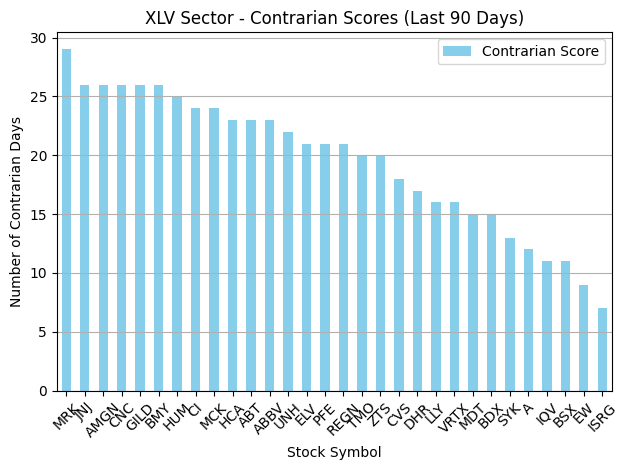


=== XLI Sector Contrarian Scores ===
      Contrarian Score
NOC                 30
LMT                 29
GD                  20
DE                  19
WM                  19
RTX                 17
PCAR                17
CSX                 16
BA                  15
FDX                 15
HON                 15
UPS                 14
UBER                14
ADP                 14
UNP                 13
ITW                 12
CTAS                12
TDG                 12
NSC                 12
CARR                10
URI                 10
MMM                  9
CAT                  8
JCI                  7
GE                   7
GEV                  6
PH                   5
ETN                  5
TT                   3
EMR                  3


<Figure size 1000x600 with 0 Axes>

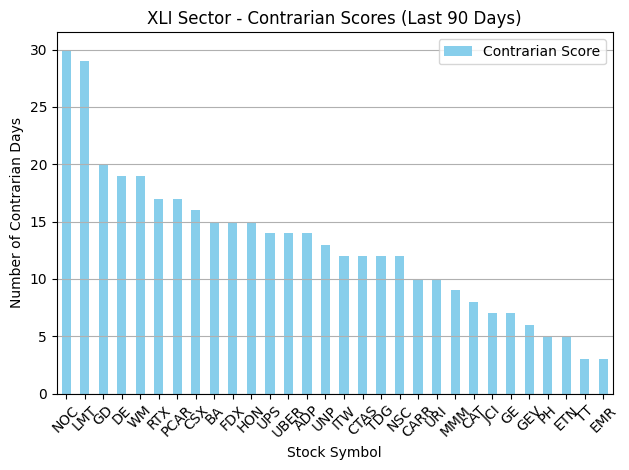


=== XLY Sector Contrarian Scores ===
      Contrarian Score
ORLY                23
NKE                 22
MCD                 21
CMG                 21
SBUX                20
AZO                 20
EBAY                19
TSCO                19
YUM                 19
DHI                 18
GPC                 18
NVR                 17
LEN                 17
PHM                 16
LULU                15
F                   15
GM                  14
ABNB                14
LOW                 14
TSLA                13
TJX                 12
DECK                12
ROST                11
BKNG                11
HD                  10
HLT                 10
RCL                  9
AMZN                 8
MAR                  8
GRMN                 8


<Figure size 1000x600 with 0 Axes>

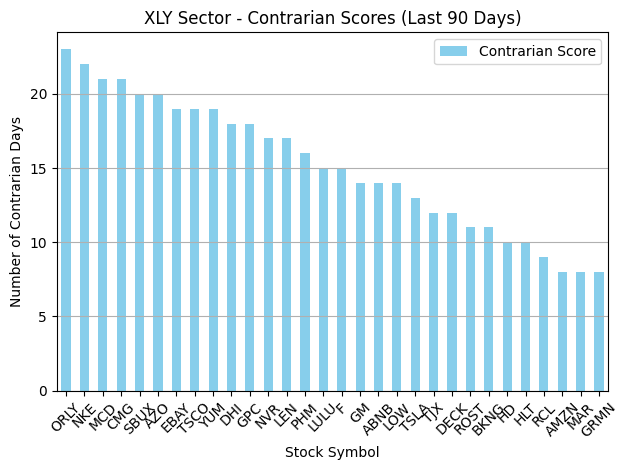


=== XLU Sector Contrarian Scores ===
      Contrarian Score
DUK                 31
ED                  31
AEP                 29
SO                  29
AWK                 29
CMS                 28
EXC                 27
FE                  27
NEE                 27
XEL                 26
WEC                 25
D                   23
ES                  22
AEE                 22
PCG                 21
AES                 21
ATO                 21
EVRG                21
EIX                 20
LNT                 19
PPL                 19
DTE                 19
NI                  16
ETR                 16
CNP                 14
SRE                 11
PEG                 10
CEG                 10
VST                  9
NRG                  9


<Figure size 1000x600 with 0 Axes>

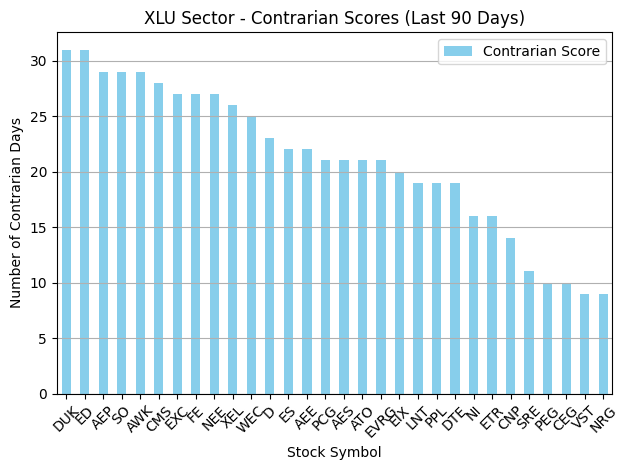


=== XLB Sector Contrarian Scores ===
      Contrarian Score
NEM                 23
CE                  23
FMC                 21
MOS                 20
ALB                 18
FCX                 18
IFF                 17
PPG                 17
AVY                 17
LYB                 17
DOW                 17
APD                 16
AMCR                16
CF                  15
EMN                 14
BALL                14
CTVA                14
STLD                13
LIN                 13
ECL                 12
PKG                 12
NUE                 11
SW                  11
DD                  11
IP                  11
SHW                  8
MLM                  8
VMC                  6


<Figure size 1000x600 with 0 Axes>

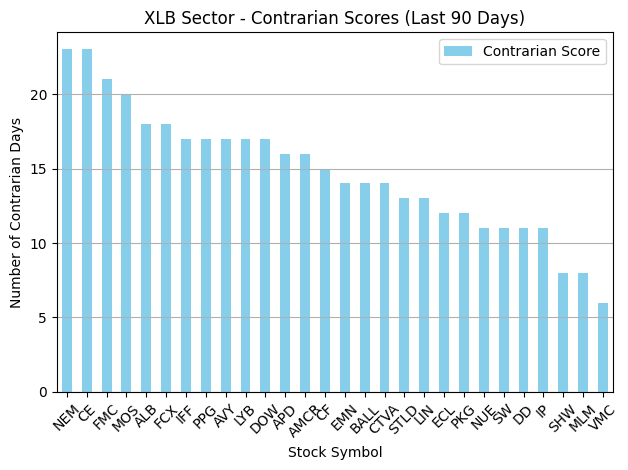


=== XLE Sector Contrarian Scores ===
      Contrarian Score
CVX                 24
HES                 24
FANG                23
DVN                 23
EOG                 22
VLO                 21
XOM                 20
OXY                 19
MPC                 19
COP                 19
CTRA                18
APA                 18
EQT                 17
PSX                 17
HAL                 17
SLB                 15
BKR                 15
OKE                 14
KMI                 12
WMB                 12
TRGP                12
MRO                  0


<Figure size 1000x600 with 0 Axes>

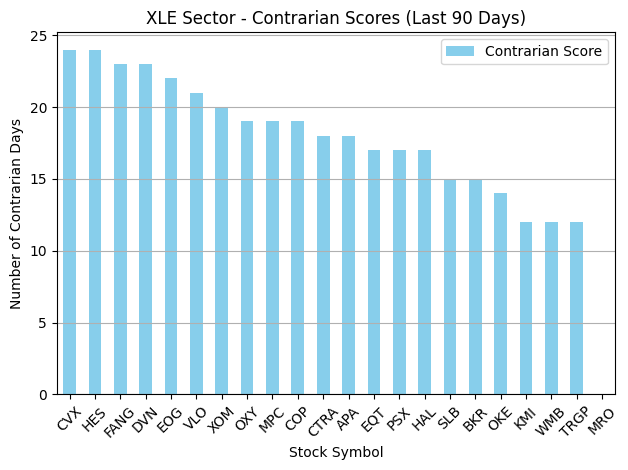


=== XLF Sector Contrarian Scores ===
      Contrarian Score
CB                  26
CME                 26
PGR                 25
AJG                 21
AFL                 19
MMC                 19
AON                 18
FI                  13
ICE                 12
TFC                 11
BLK                 10
BAC                 10
JPM                 10
COF                 10
SCHW                10
SPGI                10
PYPL                 9
MA                   9
V                    9
WFC                  9
USB                  8
KKR                  7
MCO                  7
PNC                  7
C                    6
BX                   6
AXP                  5
MS                   4
GS                   3


<Figure size 1000x600 with 0 Axes>

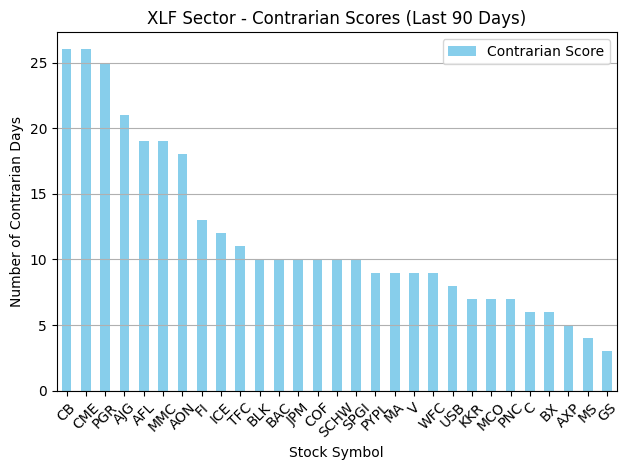


=== XLK Sector Contrarian Scores ===
      Contrarian Score
INTC                18
IBM                 14
ACN                 12
INTU                12
ADBE                12
MU                  11
NXPI                11
PANW                 9
CRM                  9
MSI                  9
AAPL                 9
ORCL                 8
NVDA                 8
AMD                  8
ROP                  8
ANET                 8
CRWD                 8
LRCX                 8
AVGO                 7
ADI                  7
CSCO                 7
TXN                  7
NOW                  7
AMAT                 7
APH                  6
MSFT                 6
QCOM                 5
KLAC                 4
CDNS                 2
SNPS                 2


<Figure size 1000x600 with 0 Axes>

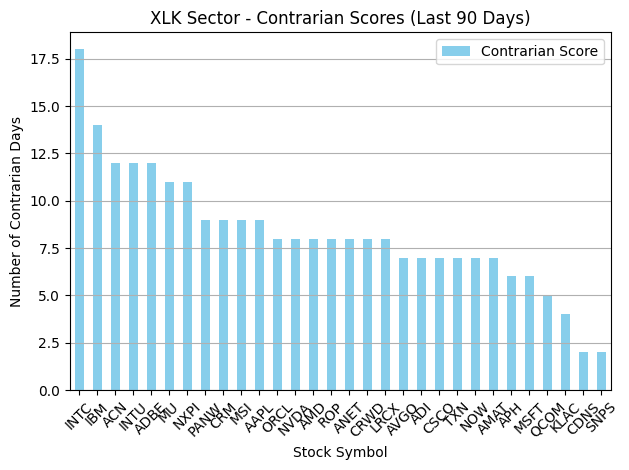


=== XLP Sector Contrarian Scores ===
      Contrarian Score
KR                  35
KDP                 32
HSY                 31
DG                  31
KMB                 31
CAG                 31
GIS                 30
MO                  30
KHC                 30
CHD                 29
CL                  29
MDLZ                29
KVUE                29
ADM                 28
TSN                 28
CLX                 27
KO                  27
MKC                 26
PEP                 23
PM                  23
PG                  23
MNST                23
STZ                 22
SYY                 21
DLTR                20
TGT                 16
EL                  16
WMT                 14
COST                12
K                    0


<Figure size 1000x600 with 0 Axes>

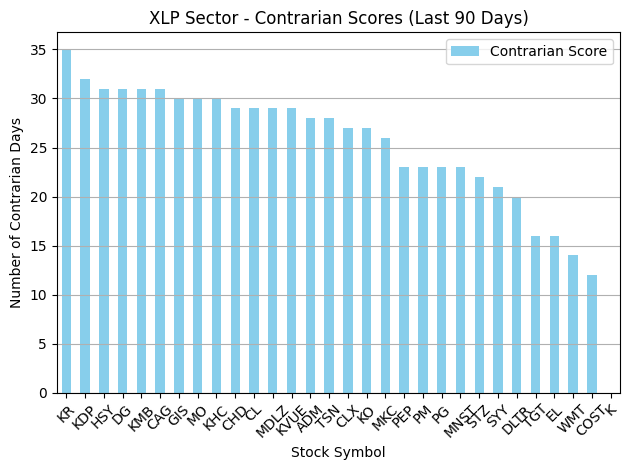


=== XLRE Sector Contrarian Scores ===
      Contrarian Score
CCI                 29
VTR                 24
O                   23
AMT                 23
SBAC                23
WELL                22
VICI                22
UDR                 20
MAA                 20
PSA                 20
EXR                 19
ESS                 18
REG                 18
AVB                 17
CPT                 17
DOC                 17
INVH                17
EQR                 17
ARE                 16
WY                  14
HST                 14
PLD                 13
KIM                 13
BXP                 12
SPG                 11
IRM                 11
CBRE                10
DLR                 10
EQIX                10
CSGP                 7


<Figure size 1000x600 with 0 Axes>

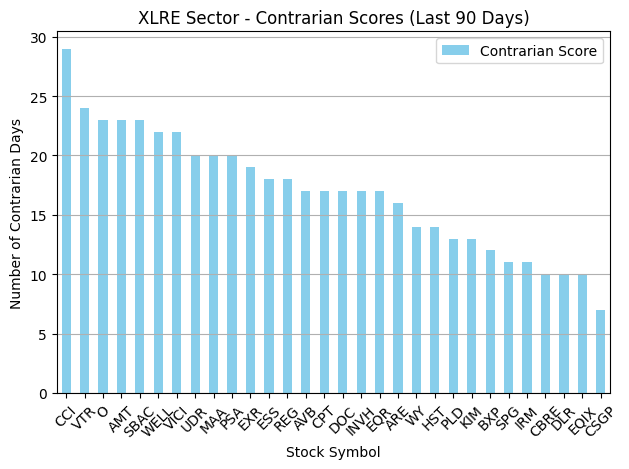


=== XLC Sector Contrarian Scores ===
       Contrarian Score
VZ                   29
OMC                  25
TMUS                 24
EA                   23
IPG                  22
T                    22
CHTR                 20
PARA                 17
WBD                  15
CMCSA                15
FOXA                 14
FOX                  14
META                 14
DIS                  14
TTWO                 12
MTCH                 11
NWS                  10
NWSA                 10
NFLX                  9
LYV                   9
GOOG                  4
GOOGL                 4


<Figure size 1000x600 with 0 Axes>

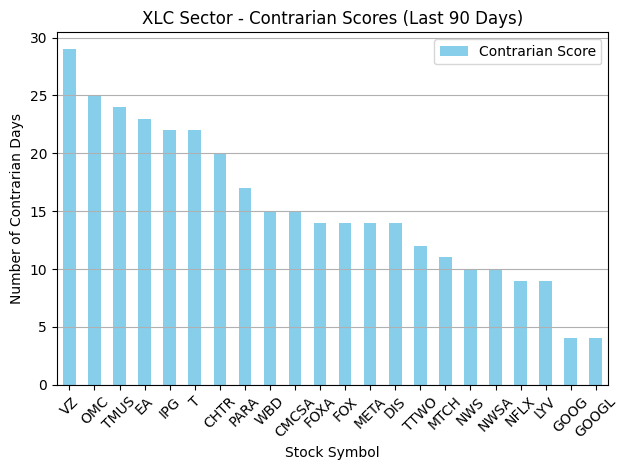

In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def get_historical_data(symbol, access_token, period_type='year', period=3, frequency_type='daily', frequency=1):
    base_url = 'https://api.schwabapi.com/marketdata/v1/pricehistory'
    headers = {
        'accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'symbol': symbol,
        'periodType': period_type,
        'period': period,
        'frequencyType': frequency_type,
        'frequency': frequency,       
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Failed to fetch data for {symbol}: {response.status_code}")
        return None

    try:
        data = response.json()
        if 'candles' not in data or not data['candles']:
            print(f"No data found for {symbol}")
            return None
        df = pd.DataFrame(data['candles'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        df['pct_change'] = df['close'].pct_change() * 100
        return df.dropna()
    except ValueError:
        print(f"Failed to parse JSON for {symbol}")
        return None

def calculate_contrarian_indicator(stocks, access_token):
    # Get SPY data (using original API parameters)
    spy_data = get_historical_data('SPY', access_token)
    if spy_data is None:
        print("Failed to get SPY data")
        return None
    
    # Get last 90 days of data
    spy_data = spy_data.tail(90)
    spy_changes = dict(zip(spy_data['datetime'], spy_data['pct_change']))
    
    contrarian_scores = {}
    
    for stock in stocks:
        stock_data = get_historical_data(stock, access_token)
        if stock_data is None:
            continue
            
        # Get last 90 days of data
        stock_data = stock_data.tail(90)
        contrarian_count = 0
        
        for _, row in stock_data.iterrows():
            date = row['datetime']
            stock_change = row['pct_change']
            
            if date in spy_changes:
                spy_change = spy_changes[date]
                
                if (spy_change > 0.3 and stock_change < -0.3) or (spy_change < -0.3 and stock_change > 0.3):
                    contrarian_count += 1
        
        contrarian_scores[stock] = contrarian_count
    
    return contrarian_scores

# Sector definitions (unchanged)
sectors = {    
    "XLV": ["LLY", "UNH", "JNJ", "ABBV", "MRK", "TMO", "ABT", "DHR", "AMGN", "ISRG","PFE", "REGN", "ELV", "VRTX", "BSX", "SYK", "MDT", "BMY", "CI", "GILD","ZTS", "CVS", "HCA", "MCK", "BDX", "IQV", "HUM", "CNC", "A", "EW"],
    "XLI": ["GE", "CAT", "RTX", "UBER", "UNP", "HON", "LMT", "ETN", "ADP", "BA", "DE", "UPS", "TT", "WM", "PH", "TDG", "MMM", "NOC", "GD", "CTAS", "ITW", "CSX", "FDX", "EMR", "CARR", "NSC", "GEV", "PCAR", "URI", "JCI"],
    "XLY": ["AMZN", "TSLA", "HD", "MCD", "LOW", "TJX", "BKNG", "SBUX", "NKE", "CMG", "ORLY", "AZO", "MAR", "DHI", "HLT", "ABNB", "GM", "ROST", "LEN", "F", "YUM", "RCL", "LULU", "EBAY", "TSCO", "NVR", "GRMN", "PHM", "DECK", "GPC"],
    "XLU": ["NEE", "SO", "DUK", "CEG", "AEP", "SRE", "D", "PEG", "PCG", "EXC", "ED", "XEL", "EIX", "WEC", "AWK", "VST", "DTE", "ETR", "ES", "PPL", "FE", "AEE", "CMS", "ATO", "NRG", "CNP", "LNT", "NI", "EVRG", "AES"],
    "XLB": ["LIN", "SHW", "FCX", "ECL", "APD", "NEM", "CTVA", "DOW", "NUE", "DD", "MLM", "VMC", "PPG", "IFF", "LYB", "SW", "BALL", "PKG", "AVY", "STLD", "IP", "AMCR", "CF", "CE", "EMN", "ALB", "MOS", "FMC"],
    "XLE": ["XOM", "CVX", "EOG", "SLB", "MPC", "COP", "PSX", "WMB", "OKE", "VLO", "KMI", "OXY", "HES", "BKR", "FANG", "TRGP", "DVN", "HAL", "EQT", "CTRA", "MRO", "APA"],
    "XLF": ["JPM", "V", "MA", "BAC", "WFC", "GS", "SPGI", "AXP", "PGR", "MS", "BLK", "C", "CB", "MMC", "FI", "SCHW", "BX", "ICE", "KKR", "CME", "MCO", "AON", "PYPL", "PNC", "USB", "AJG", "TFC", "COF", "AFL"],
    "XLK": ["NVDA", "MSFT", "AAPL", "AVGO", "CRM", "ADBE", "AMD", "ORCL", "ACN", "CSCO", "QCOM", "INTU", "TXN", "IBM", "AMAT", "NOW", "MU", "LRCX", "ADI", "PANW", "KLAC", "INTC", "ANET", "SNPS", "APH", "CDNS", "MSI", "NXPI", "CRWD", "ROP"],
    "XLP": ["PG", "COST", "WMT", "KO", "PM", "PEP", "MDLZ", "MO", "CL", "TGT", "KMB", "KVUE", "GIS", "STZ", "SYY", "KDP", "KR", "MNST", "ADM", "HSY", "KHC", "DG", "CHD", "EL", "K", "DLTR", "MKC", "CLX", "TSN", "CAG"], 
    "XLRE": ["PLD", "AMT", "EQIX", "WELL", "O", "SPG", "PSA", "DLR", "CCI", "EXR", "CBRE", "VICI", "IRM", "AVB", "CSGP", "EQR", "VTR", "SBAC", "WY", "INVH", "ESS", "ARE", "MAA", "DOC", "KIM", "CPT", "UDR", "HST", "REG", "BXP"],
    "XLC": ["META", "GOOGL", "GOOG", "CHTR", "TMUS", "T", "EA", "CMCSA", "NFLX", "VZ", "DIS", "TTWO", "OMC", "WBD", "LYV", "IPG", "NWSA", "MTCH", "FOXA", "PARA", "FOX", "NWS"]
}

access_token = get_new_tokens()

# Calculate and display contrarian scores for each sector separately
for sector_name, stocks in sectors.items():
    print(f"\n=== {sector_name} Sector Contrarian Scores ===")
    
    # Calculate contrarian scores for this sector
    sector_scores = calculate_contrarian_indicator(stocks, access_token)
    
    if sector_scores:
        # Create DataFrame and sort
        sector_df = pd.DataFrame.from_dict(sector_scores, orient='index', 
                                         columns=['Contrarian Score'])
        sector_df.sort_values(by='Contrarian Score', ascending=False, inplace=True)
        
        # Display results
        print(sector_df)
        
        # Visualization for this sector
        plt.figure(figsize=(10, 6))
        sector_df.plot(kind='bar', color='skyblue')
        plt.title(f'{sector_name} Sector - Contrarian Scores (Last 90 Days)')
        plt.xlabel('Stock Symbol')
        plt.ylabel('Number of Contrarian Days')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No contrarian data available for {sector_name} sector")


=== XLV Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
HCA                19
JNJ                17
CI                 17
AMGN               17
ELV                16
MRK                16
GILD               16
MCK                16
UNH                15
BMY                15
CNC                14
ABT                14
ABBV               13
VRTX               13
HUM                13
REGN               12
ZTS                12
MDT                11
LLY                11
BDX                10
DHR                10
PFE                10
CVS                10
BSX                 9
SYK                 8
TMO                 8
EW                  5
ISRG                4
IQV                 4
A                   3


<Figure size 1000x600 with 0 Axes>

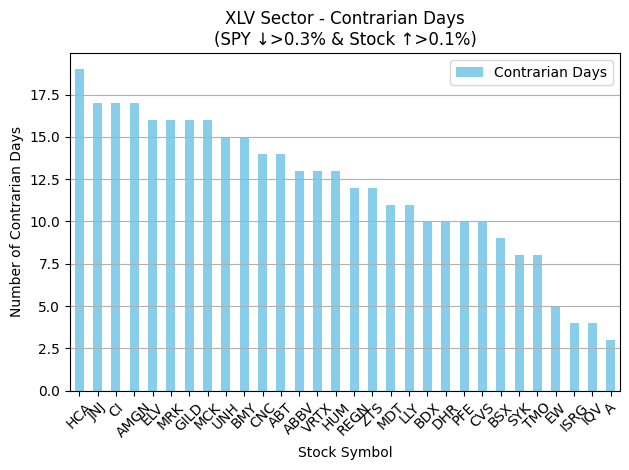


=== XLI Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
NOC                19
LMT                17
WM                 15
GD                 14
BA                 12
RTX                11
UPS                10
FDX                10
ADP                10
UBER               10
TDG                 9
UNP                 9
HON                 9
PCAR                8
CTAS                8
NSC                 7
CSX                 7
GEV                 7
DE                  7
MMM                 6
ITW                 6
GE                  6
CARR                4
URI                 4
CAT                 3
ETN                 3
TT                  3
EMR                 3
JCI                 3
PH                  2


<Figure size 1000x600 with 0 Axes>

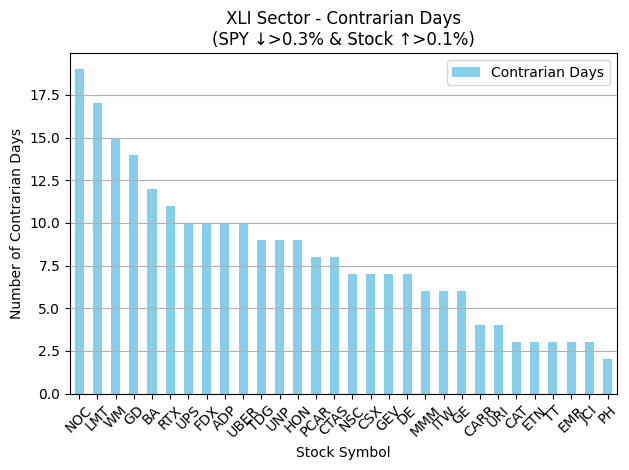


=== XLY Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
MCD                15
AZO                14
SBUX               13
ORLY               13
YUM                13
GPC                12
EBAY               12
TSCO               12
F                  11
GM                 10
NKE                10
DHI                10
CMG                 9
LULU                9
LEN                 8
TJX                 7
NVR                 6
PHM                 6
LOW                 6
MAR                 6
ABNB                6
RCL                 5
DECK                4
ROST                4
BKNG                4
HD                  4
TSLA                3
AMZN                3
HLT                 3
GRMN                3


<Figure size 1000x600 with 0 Axes>

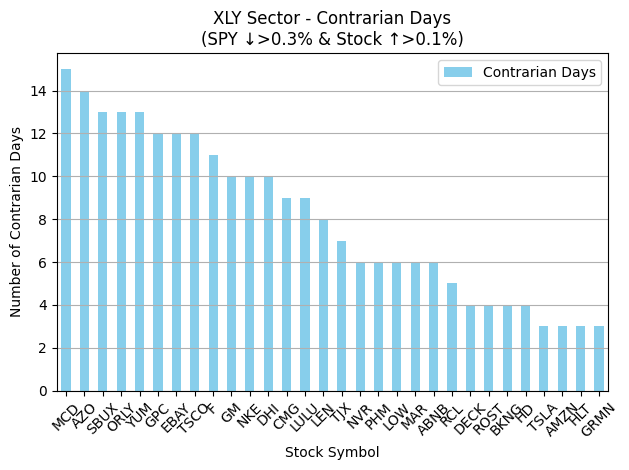


=== XLU Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
AEP                21
CMS                21
DTE                19
FE                 18
AWK                18
ED                 18
SO                 17
DUK                16
D                  16
PPL                16
EXC                16
XEL                16
EVRG               15
WEC                15
ES                 14
AEE                14
CNP                13
ATO                13
PCG                13
NEE                12
NI                 12
ETR                11
LNT                11
AES                10
VST                 9
EIX                 9
SRE                 8
CEG                 7
PEG                 7
NRG                 6


<Figure size 1000x600 with 0 Axes>

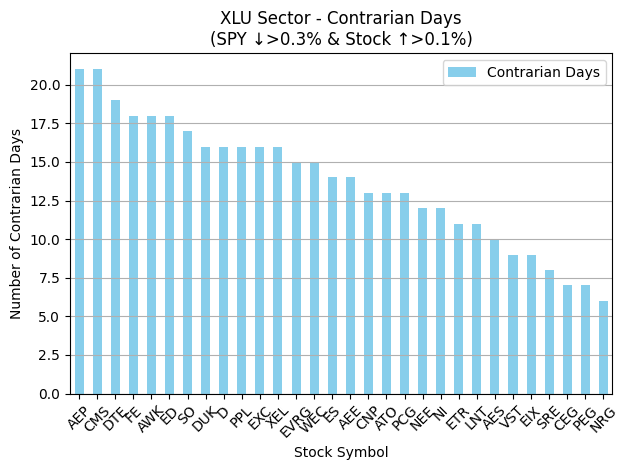


=== XLB Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
NEM                17
FMC                15
CE                 13
CF                 13
MOS                11
FCX                11
EMN                10
IFF                 9
NUE                 9
BALL                9
DOW                 8
LIN                 8
PPG                 8
AMCR                8
AVY                 8
STLD                8
ECL                 8
LYB                 8
APD                 7
CTVA                7
IP                  7
ALB                 7
DD                  6
SW                  5
SHW                 4
VMC                 4
MLM                 3
PKG                 3


<Figure size 1000x600 with 0 Axes>

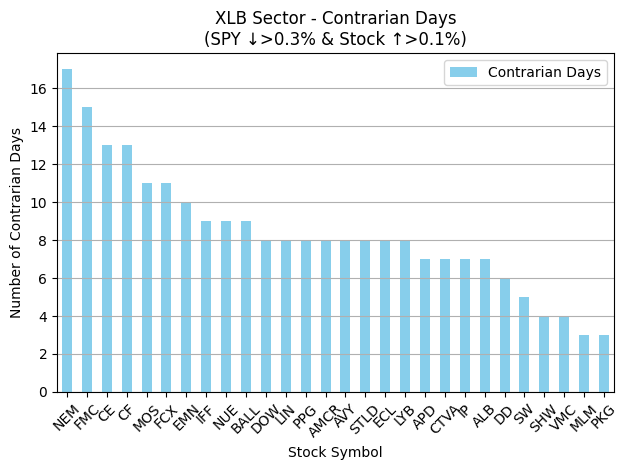


=== XLE Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
No data found for MRO
      Contrarian Days
CVX                15
EOG                15
XOM                14
OXY                14
COP                14
EQT                14
APA                14
DVN                13
MPC                13
HES                13
FANG               13
CTRA               13
VLO                12
KMI                11
SLB                10
PSX                 9
TRGP                9
HAL                 8
BKR                 7
WMB                 6
OKE                 6


<Figure size 1000x600 with 0 Axes>

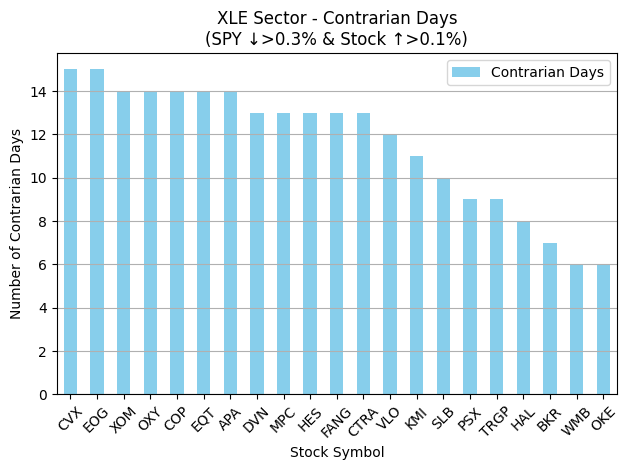


=== XLF Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
CME                21
AJG                19
CB                 17
PGR                14
AFL                13
MMC                13
AON                11
V                  10
MA                  9
ICE                 8
FI                  7
JPM                 7
COF                 6
PYPL                5
USB                 5
SCHW                5
WFC                 5
C                   5
BLK                 5
BAC                 5
PNC                 4
MCO                 3
TFC                 3
MS                  3
SPGI                3
KKR                 2
BX                  2
GS                  1
AXP                 1


<Figure size 1000x600 with 0 Axes>

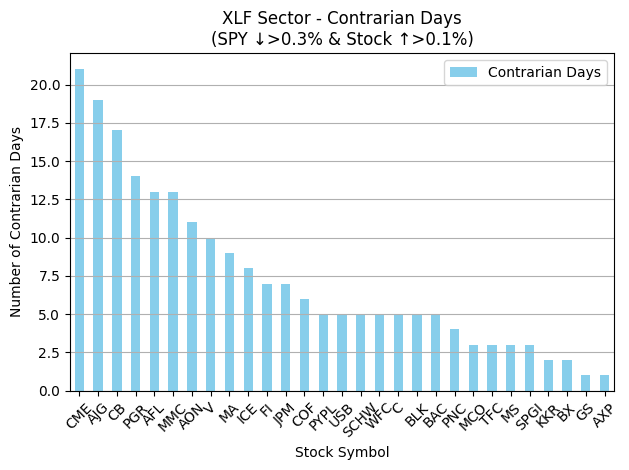


=== XLK Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
ROP                10
IBM                 9
PANW                8
ANET                7
INTC                7
CSCO                7
MSI                 7
CRWD                7
AMD                 6
NXPI                6
ADBE                6
ACN                 6
TXN                 5
NVDA                5
MU                  5
KLAC                5
LRCX                5
AMAT                5
AAPL                5
AVGO                4
CRM                 4
QCOM                4
CDNS                4
SNPS                4
NOW                 4
INTU                3
ADI                 3
MSFT                2
ORCL                2
APH                 2


<Figure size 1000x600 with 0 Axes>

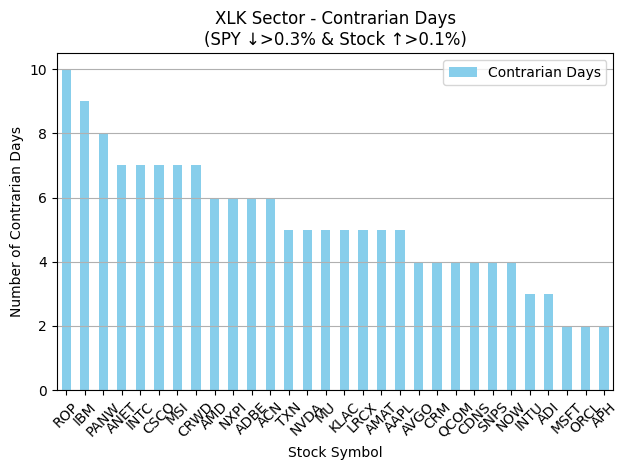


=== XLP Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
KR                 22
KMB                21
DG                 19
MDLZ               19
PM                 18
MO                 18
KDP                18
ADM                17
HSY                17
KHC                16
CHD                16
CAG                16
CL                 16
PG                 16
CLX                15
TSN                15
GIS                15
MKC                14
KVUE               14
PEP                14
KO                 12
MNST               12
SYY                12
DLTR               11
WMT                10
STZ                10
COST                8
TGT                 7
EL                  7
K                   6


<Figure size 1000x600 with 0 Axes>

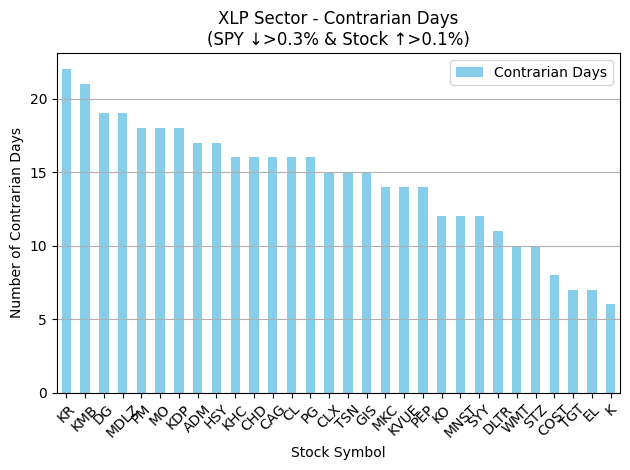


=== XLRE Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
CCI                17
AMT                16
WELL               16
SBAC               15
O                  14
VTR                13
MAA                12
INVH               12
VICI               12
CPT                12
ESS                11
EQR                10
UDR                10
PSA                10
REG                 9
DOC                 9
WY                  9
AVB                 9
EXR                 9
CSGP                8
ARE                 8
EQIX                7
DLR                 7
IRM                 6
PLD                 6
SPG                 6
BXP                 6
KIM                 6
CBRE                4
HST                 4


<Figure size 1000x600 with 0 Axes>

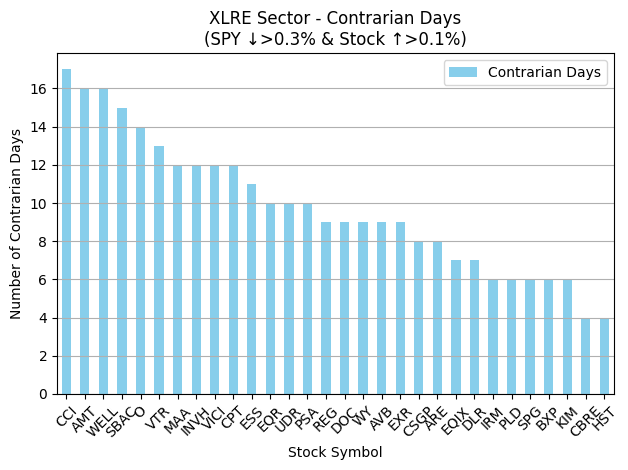


=== XLC Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
       Contrarian Days
VZ                  16
TMUS                15
T                   15
EA                  13
PARA                13
CHTR                11
OMC                 11
NWS                 10
CMCSA               10
META                 9
IPG                  9
TTWO                 9
WBD                  9
NFLX                 8
FOX                  8
NWSA                 8
FOXA                 8
DIS                  7
MTCH                 7
LYV                  6
GOOG                 3
GOOGL                3


<Figure size 1000x600 with 0 Axes>

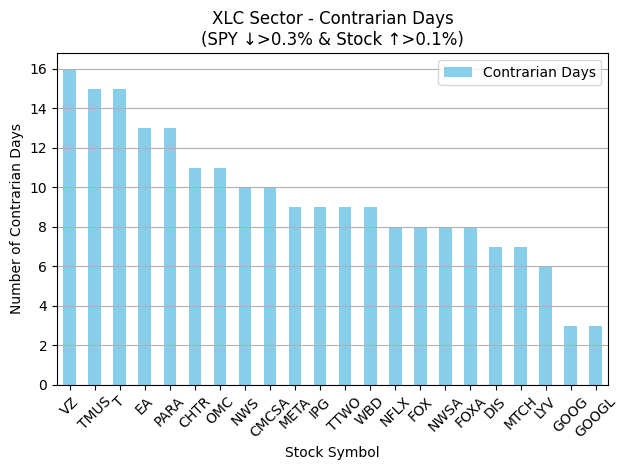


=== DXYZ Sector Contrarian Scores ===
(Days when SPY dropped >0.3% and stock rose >0.1%)
      Contrarian Days
NOV                10
HAL                 8
COHR                4
SYM                 3
DXYZ                1


<Figure size 1000x600 with 0 Axes>

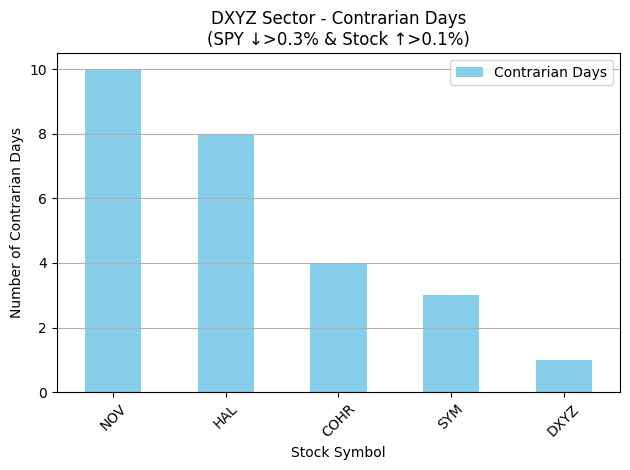

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def get_historical_data(symbol, access_token, period_type='year', period=3, frequency_type='daily', frequency=1):
    base_url = 'https://api.schwabapi.com/marketdata/v1/pricehistory'
    headers = {
        'accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'symbol': symbol,
        'periodType': period_type,
        'period': period,
        'frequencyType': frequency_type,
        'frequency': frequency,       
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Failed to fetch data for {symbol}: {response.status_code}")
        return None

    try:
        data = response.json()
        if 'candles' not in data or not data['candles']:
            print(f"No data found for {symbol}")
            return None
        df = pd.DataFrame(data['candles'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        df['pct_change'] = df['close'].pct_change() * 100
        return df.dropna()
    except ValueError:
        print(f"Failed to parse JSON for {symbol}")
        return None

def calculate_contrarian_indicator(stocks, access_token):
    # Get SPY data (using original API parameters)
    spy_data = get_historical_data('SPY', access_token)
    if spy_data is None:
        print("Failed to get SPY data")
        return None
    
    # Get last 90 days of data
    spy_data = spy_data.tail(90)
    spy_changes = dict(zip(spy_data['datetime'], spy_data['pct_change']))
    
    contrarian_scores = {}
    
    for stock in stocks:
        stock_data = get_historical_data(stock, access_token)
        if stock_data is None:
            continue
            
        # Get last 90 days of data
        stock_data = stock_data.tail(90)
        contrarian_count = 0
        
        for _, row in stock_data.iterrows():
            date = row['datetime']
            stock_change = row['pct_change']
            
            if date in spy_changes:
                spy_change = spy_changes[date]
                
                # Only count when SPY drops >0.3% and stock rises >0.1%
                if spy_change < -0.3 and stock_change > 0.1:
                    contrarian_count += 1
        
        contrarian_scores[stock] = contrarian_count
    
    return contrarian_scores

# Sector definitions (unchanged)
sectors = {    
    "XLV": ["LLY", "UNH", "JNJ", "ABBV", "MRK", "TMO", "ABT", "DHR", "AMGN", "ISRG","PFE", "REGN", "ELV", "VRTX", "BSX", "SYK", "MDT", "BMY", "CI", "GILD","ZTS", "CVS", "HCA", "MCK", "BDX", "IQV", "HUM", "CNC", "A", "EW"],
    "XLI": ["GE", "CAT", "RTX", "UBER", "UNP", "HON", "LMT", "ETN", "ADP", "BA", "DE", "UPS", "TT", "WM", "PH", "TDG", "MMM", "NOC", "GD", "CTAS", "ITW", "CSX", "FDX", "EMR", "CARR", "NSC", "GEV", "PCAR", "URI", "JCI"],
    "XLY": ["AMZN", "TSLA", "HD", "MCD", "LOW", "TJX", "BKNG", "SBUX", "NKE", "CMG", "ORLY", "AZO", "MAR", "DHI", "HLT", "ABNB", "GM", "ROST", "LEN", "F", "YUM", "RCL", "LULU", "EBAY", "TSCO", "NVR", "GRMN", "PHM", "DECK", "GPC"],
    "XLU": ["NEE", "SO", "DUK", "CEG", "AEP", "SRE", "D", "PEG", "PCG", "EXC", "ED", "XEL", "EIX", "WEC", "AWK", "VST", "DTE", "ETR", "ES", "PPL", "FE", "AEE", "CMS", "ATO", "NRG", "CNP", "LNT", "NI", "EVRG", "AES"],
    "XLB": ["LIN", "SHW", "FCX", "ECL", "APD", "NEM", "CTVA", "DOW", "NUE", "DD", "MLM", "VMC", "PPG", "IFF", "LYB", "SW", "BALL", "PKG", "AVY", "STLD", "IP", "AMCR", "CF", "CE", "EMN", "ALB", "MOS", "FMC"],
    "XLE": ["XOM", "CVX", "EOG", "SLB", "MPC", "COP", "PSX", "WMB", "OKE", "VLO", "KMI", "OXY", "HES", "BKR", "FANG", "TRGP", "DVN", "HAL", "EQT", "CTRA", "MRO", "APA"],
    "XLF": ["JPM", "V", "MA", "BAC", "WFC", "GS", "SPGI", "AXP", "PGR", "MS", "BLK", "C", "CB", "MMC", "FI", "SCHW", "BX", "ICE", "KKR", "CME", "MCO", "AON", "PYPL", "PNC", "USB", "AJG", "TFC", "COF", "AFL"],
    "XLK": ["NVDA", "MSFT", "AAPL", "AVGO", "CRM", "ADBE", "AMD", "ORCL", "ACN", "CSCO", "QCOM", "INTU", "TXN", "IBM", "AMAT", "NOW", "MU", "LRCX", "ADI", "PANW", "KLAC", "INTC", "ANET", "SNPS", "APH", "CDNS", "MSI", "NXPI", "CRWD", "ROP"],
    "XLP": ["PG", "COST", "WMT", "KO", "PM", "PEP", "MDLZ", "MO", "CL", "TGT", "KMB", "KVUE", "GIS", "STZ", "SYY", "KDP", "KR", "MNST", "ADM", "HSY", "KHC", "DG", "CHD", "EL", "K", "DLTR", "MKC", "CLX", "TSN", "CAG"], 
    "XLRE": ["PLD", "AMT", "EQIX", "WELL", "O", "SPG", "PSA", "DLR", "CCI", "EXR", "CBRE", "VICI", "IRM", "AVB", "CSGP", "EQR", "VTR", "SBAC", "WY", "INVH", "ESS", "ARE", "MAA", "DOC", "KIM", "CPT", "UDR", "HST", "REG", "BXP"],
    "XLC": ["META", "GOOGL", "GOOG", "CHTR", "TMUS", "T", "EA", "CMCSA", "NFLX", "VZ", "DIS", "TTWO", "OMC", "WBD", "LYV", "IPG", "NWSA", "MTCH", "FOXA", "PARA", "FOX", "NWS"],
    "DXYZ":["DXYZ","SYM","COHR","NOV","HAL"]
}

access_token = get_new_tokens()

# Calculate and display contrarian scores for each sector separately
for sector_name, stocks in sectors.items():
    print(f"\n=== {sector_name} Sector Contrarian Scores ===")
    print(f"(Days when SPY dropped >0.3% and stock rose >0.1%)")
    
    # Calculate contrarian scores for this sector
    sector_scores = calculate_contrarian_indicator(stocks, access_token)
    
    if sector_scores:
        # Create DataFrame and sort
        sector_df = pd.DataFrame.from_dict(sector_scores, orient='index', 
                                         columns=['Contrarian Days'])
        sector_df.sort_values(by='Contrarian Days', ascending=False, inplace=True)
        
        # Display results
        print(sector_df)
        
        # Visualization for this sector
        plt.figure(figsize=(10, 6))
        sector_df.plot(kind='bar', color='skyblue')
        plt.title(f'{sector_name} Sector - Contrarian Days\n(SPY ↓>0.3% & Stock ↑>0.1%)')
        plt.xlabel('Stock Symbol')
        plt.ylabel('Number of Contrarian Days')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No contrarian data available for {sector_name} sector")